In [83]:
import pandas as pd
import numpy as np
import wikipedia as wiki
from bs4 import BeautifulSoup
from optional import Optional
import geocoder
import random
import wptools
import requests



import os
os.environ["PROJ_LIB"] = "C:\\Users\\Tali\\Anaconda3\\Library\\share";
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)



In [115]:
def getArtistOrigin(name: str):
    result = getOriginFromMusicbrainz(name)
    
    if result.is_empty():
        result = getOriginFromWikipedia(name + "Musician")
    
    if result.is_empty():
        result = getOriginFromWikidata(name)
    
    if result.is_present():
        toReturn = result.get()
    else:
        print("Still not found!", name)
        toReturn = "Not Found"
        
    return toReturn


def getOriginFromMusicbrainz(name: str):
    toReturn = Optional.empty()
    location = ""

    
    url = "https://musicbrainz.org/search?query="+name+"%2056&type=artist&method=indexed"
    page = requests.get(url)

    print(page)
    bs = BeautifulSoup(page.content)
    
    table = bs.find_all("table")
    
    titles = [title.text.strip() for title in table[0].find_all("th")]
    artist_data = []
    for data in table[0].find_all("td"):
        if len(artist_data) < len(titles):
            artist_data.append(data.text.strip())
        else:
            break
            
    
    for key, value in zip (titles, artist_data):
        if (key == "Area" or key == "Begin Area"):
            location += " " + value
        
    if location!= "":
        toReturn = Optional.of(location)
        
    return toReturn


def getOriginFromWikipedia(name: str):
    toReturn = Optional.empty()
    artistPage = wiki.page(wiki.search(name)[0], auto_suggest=False).html()
    
    bs = BeautifulSoup(artistPage)
    
    tables = bs.find_all("table")
    
    tab = None
    for tab in tables:
        if "infobox" in tab["class"]:
            break
            
    if tab != None:
        # search for 'origin' to return
        titles = [heading.text.strip() for heading in tab.find_all("th")]
        titles.pop(0)
        data = [data.text.strip() for data in tab.find_all("td")]

        for key, value in zip(titles, data):
            if key =="Origin":
                toReturn = Optional.of(value)
                
        # edge case for some solo artists, find birthplace
        if toReturn == Optional.empty():
            for div in tab.find_all("div", {"class": "birthplace"}):
                if "birthplace" in div["class"]:
                    toReturn = Optional.of(div.text.strip())
        
        # worse case, birthplace not tagged
        if toReturn == Optional.empty():
            for key, value in zip(titles, data):
                if key =="Born":
                    try:
                        index = value.index("age")
                    except:
                        index = 0
                    value = value[index+7:]
                    toReturn = Optional.of(value)
                if key =="Died":
                    try:
                        index = value.index("age")
                    except:
                        index = 0
                    index = value.index("age")
                    value = value[index+7:]
                    toReturn = Optional.of(value)
    return toReturn

def getOriginFromWikidata(name: str):
    toReturn = Optional.empty()
    placeOfBirth = None
    
    page = wptools.page(name)
    try:
        page.get_wikidata()
    except:
        print("Couldn't get wikidata from name.")
        
    try:
        placeOfBirth = page.data['wikidata']['place of birth (P19)']
    except:
        None
    
    try: 
        placeOfBirth = page.data['wikidata']['location of formation (P740)']
    except:
        None
        
    try:
        index = placeOfBirth.index("(")
        placeOfBirth = placeOfBirth[0: index]
    except:
        None
        
    if placeOfBirth != None:
        toReturn = Optional.of(placeOfBirth)
    
    return toReturn



In [116]:
getOriginFromMusicbrainz("Hamada Kingo")

<Response [200]>


Optional.of(' Japan Shinjuku')

In [117]:
def createDataframe(artist_list):
    location_name = [getArtistOrigin(artist) for artist in artist_list]
    location_coord = [getLocationByGeo(loc) for loc in location_name]
    df = pd.DataFrame({"artist_name" : artist_list, "location_name" : location_name, "location_coord": location_coord })
    return df
                     
## https://stackoverflow.com/questions/56873950/convert-place-name-to-coordinates-by-geopy
def getLocationByGeo(name):
    try: 
        index = name.index("[")
        name = name[0:index]
    except:
        name = name
    g = geocoder.osm(name)
    return g.latlng

In [118]:
sample_artists = ["paul simon", "kingo hamada", "midnight oil", "dodie", "vampire weekend"]
df = createDataframe(sample_artists)
df

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


,artist_name,location_name,location_coord
0,paul simon,United States Newark,"[40.735657, -74.1723667]"
1,kingo hamada,Japan Shinjuku,"[35.6937632, 139.7036319]"
2,midnight oil,Australia Sydney,"[-33.8548157, 151.2164539]"
3,dodie,Enfield Enfield,"[51.6520851, -0.0810175]"
4,vampire weekend,United States New York,"[40.7127281, -74.0060152]"


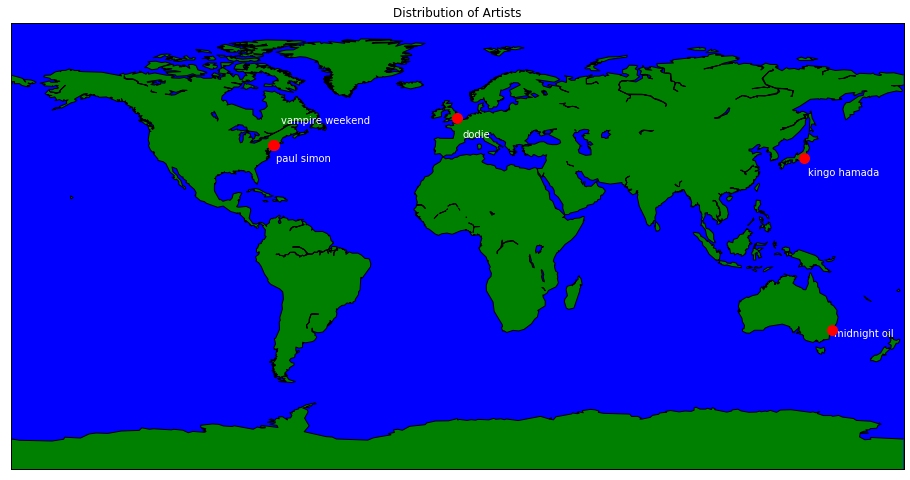

In [119]:
fig = plt.figure(figsize=(16, 10), edgecolor='w')
m = Basemap(projection='cyl', lat_0=0, lon_0=0)

m.drawmapboundary(fill_color='blue')
m.fillcontinents(color='green',lake_color='blue')
m.drawcoastlines()

plt.title("Distribution of Artists")


lons = []
lats = []
for coord in df["location_coord"]:
    lats.append(coord[0])
    lons.append(coord[1])

x, y = m(lons, lats)  # transform coordinates
m.scatter(x, y, 100, marker='o', color='Red', zorder=10) 
for i, name in enumerate(df["artist_name"]):
    plt.annotate(name, xy=(x[i], y[i]), xytext=(x[i] + 5*(random.random()), y[i] + 20*(random.random() - 0.5) ), xycoords='data', color='w')
plt.show()

[]


Optional.empty()